Using TensorFlow backend.


Configuration:
  crop_lower, Value: 0.09535121340727055
  crop_upper, Value: 0.13133166453087944
  horizontal_flip, Value: 0.6902642523341844
  pad_lower, Value: 0.02383836034742606
  pad_upper, Value: 0.21726914590950042
  rotation_lower, Value: -49
  rotation_probability, Value: 0.9295252514462219
  rotation_upper, Value: 122
  scale_lower, Value: 0.7889186061849662
  scale_upper, Value: 1.1839521037708594
  vertical_flip, Value: 0.3017699886386509



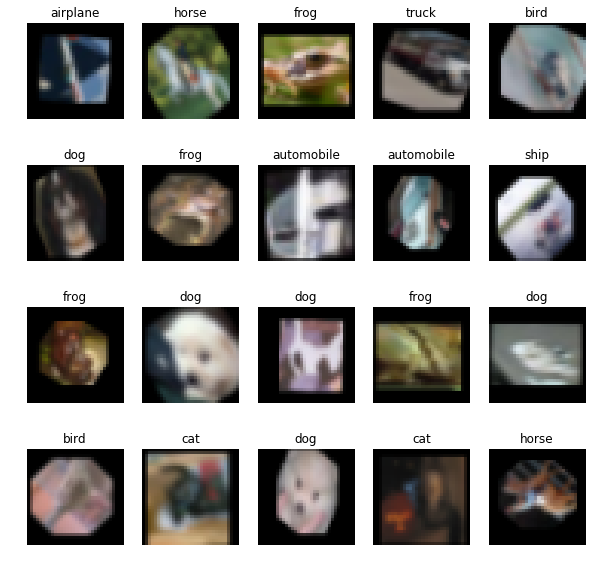

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import keras
from keras.datasets import cifar10
from os.path import abspath, join as path_join
PARENT_DIR =  path_join(os.getcwd(), "..")
sys.path.insert(0, PARENT_DIR)

from autoda.preprocessing import generate_batches
from autoda.data_augmentation import ImageAugmentation


import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap

ia.seed(1)

labels_dict = {0:"airplane", 1: "automobile", 2: "bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog",
               7:"horse", 8:"ship", 9:"truck"}
sample_config = ImageAugmentation.get_config_space().sample_configuration()

#sample_config["crop"] = -5
#sample_config["pad"] = 1
#sample_config["rotation_probability"] = 0
#sample_config["scale_lower"] = 0.6
#sample_config["scale_upper"] = 2.
print(sample_config)

(x_train, y_train), _ = cifar10.load_data()
augmenter = ImageAugmentation(sample_config)
aug_batch, y = next(augmenter.apply_transform(x_train, y_train, batch_size=20))
#for i in range(y.shape[0]):
#    print(labels_dict[y[i][0]])


#Visualizing CIFAR 10
fig, axes1 = plt.subplots(4,5,figsize=(10,10))
i = 0
for j in range(4):
    for k in range(5):
        label_index = labels_dict[y[i][0]]
        axes1[j][k].set_title('{}'.format(label_index))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(aug_batch[i:i+1][0])
        i+=1
        
